In [1]:
import torch
import torch.nn as nn
from torch.nn import GRU, Linear, LSTM, Conv1d
import torch.nn.functional as F
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

In [2]:
# Training parameters
DI_path = "ht1-input.wav"
target_path = "ht1-target.wav"
# DI_path = "DI.wav"
# target_path = "target.wav"
need_compensate_delay = True
train_val_ratio = 0.8
input_size = 1
hidden_size = 32
epochs = 100
batch_size = 200
sequence_size = 256
window_size = 22050
lr = 1e-3
name = 'test'

Read ht1-input.wav with 14994001 samples, rate is 44100Hz
Read ht1-target.wav with 14994001 samples, rate is 44100Hz


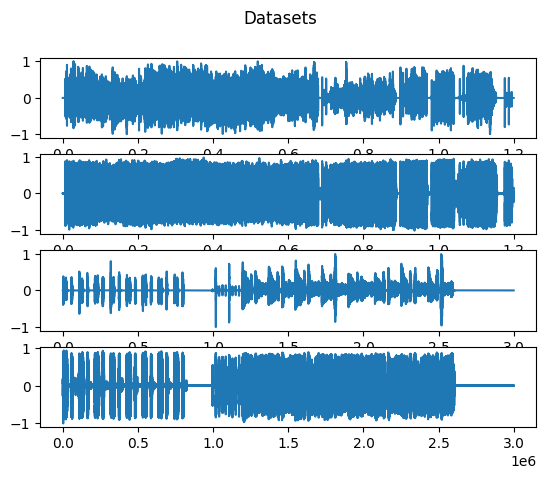

Using GPU for training


In [3]:
# wavfile utils
def read_wav_file(path, normalize=True, bitwidth=16):
    rate, sig = wavfile.read(path)
    print("Read {} with {} samples, rate is {}Hz".format(path, len(sig), rate))
    sig = np.float32(sig)
    if normalize == True:
        return rate, 2 * (sig - sig.mean()) / (sig.max() - sig.min())  # Normalized
    return rate, sig

def write_wav_file(path, sig, rate, normalized=True, bitwidth=16):
    if normalized == True:
        _range = float(np.power(2, bitwidth-1))
        for i in range(len(sig)):
            sig[i] *= _range
    wavfile.write(path, rate, sig.astype(np.int16))

def window_array(input, window_size):
    input_len = len(input)
    window_cnt = math.floor(input_len / window_size)
    window = np.zeros((window_cnt, window_size))
    for i in range(window_cnt):
        window[i] = input[i*window_size : i*window_size+window_size]
    return window.reshape(window_cnt, window_size, -1).astype(np.float32)

# Load dataset
_, DI_dataset = read_wav_file(DI_path)
_, target_dataset = read_wav_file(target_path)
# Verify dataset length
if len(DI_dataset) != len(target_dataset):
    print("DI length and target length is not equal")
    sys.exit()
trainset_size = int(len(DI_dataset)*train_val_ratio)
input_trainset = DI_dataset[:trainset_size]
input_valset = DI_dataset[trainset_size:]
target_trainset = target_dataset[:trainset_size]
target_valset = target_dataset[trainset_size:]
# Plot original datasets
fig, ax = plt.subplots(4)
fig.suptitle("Datasets")
ax[0].plot(input_trainset)
ax[1].plot(target_trainset)
ax[2].plot(input_valset)
ax[3].plot(target_valset)
plt.show()

# Split datasets to frames
input_trainset = window_array(input_trainset, window_size)
input_valset = window_array(input_valset, window_size)
target_trainset = window_array(target_trainset, window_size)
target_valset = window_array(target_valset, window_size)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU for training")
else:
    device = torch.device("cpu")
    print("Using CPU for training")

input_trainset = torch.from_numpy(input_trainset).to(device)
input_valset = torch.from_numpy(input_valset).to(device)
target_trainset = torch.from_numpy(target_trainset).to(device)
target_valset = torch.from_numpy(target_valset).to(device)

In [4]:
# Define model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=1, num_layers=1, output_size=1):
        super().__init__()
        self.rec = LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lin = Linear(hidden_size, output_size)

    def forward(self, input):
        rec_out, self.hidden_cell = self.rec(input)
        output = self.lin(rec_out)
        return output

    def reset_hidden(self):
        self.hidden_cell = None

class ESR(nn.Module):
    def __init__(self):
        super().__init__()

    def pre_emphasis_filter(self, x, coef=0.85):
        return torch.cat((x, x - coef*x), 1)

    def forward(self, x, y):
        x = self.pre_emphasis_filter(x)
        y = self.pre_emphasis_filter(y)
        return torch.sum(torch.pow(x - y, 2)) / torch.sum(torch.pow(y, 2))

# Create model
model = RNNModel(input_size, hidden_size)
# model = torch.load("test.pth")
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
model.to(device)
print(model)

RNNModel(
  (rec): LSTM(1, 32, batch_first=True)
  (lin): Linear(in_features=32, out_features=1, bias=True)
)


In [5]:
def adjust_lr(optimizer, epoch, start_lr):
    lr = start_lr * (0.8 ** (epoch // 100))
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Training
for i in range(epochs):
    # # Shuffle data
    shuffle = torch.randperm(input_trainset.shape[0])
    input_trainset = input_trainset[shuffle]
    target_trainset = target_trainset[shuffle]
    adjust_lr(optimizer, i, lr)
    loss = 0
    for j in range(math.ceil(input_trainset.shape[0] / batch_size)):
        input_batch = input_trainset[j*batch_size : j*batch_size+batch_size, :, :]
        target_batch = target_trainset[j*batch_size : j*batch_size+batch_size, :, :]
        batch_loss = 0
        for k in range(math.ceil(input_batch.shape[1] / sequence_size)):
            optimizer.zero_grad()
            pred = model(input_batch[:, k*sequence_size : k*sequence_size+sequence_size, :])
            single_loss = loss_function(pred, target_batch[:, k*sequence_size : k*sequence_size+sequence_size, :])
            single_loss.backward()
            optimizer.step()
            batch_loss += single_loss
            model.reset_hidden()
        batch_loss /= (k + 1)
        loss += batch_loss
        # print("Batch {} loss {}".format(j, batch_loss), end='\r')
    loss /= (j + 1)
    if i % 25 == 0:
      print("Epoch {} loss {}".format(i, loss))

torch.save(model, name+".pth")

Epoch 0 loss 0.14142510294914246
Epoch 25 loss 0.07487234473228455
Epoch 50 loss 0.06272900104522705
Epoch 75 loss 0.056569091975688934


Val loss 0.02620694786310196


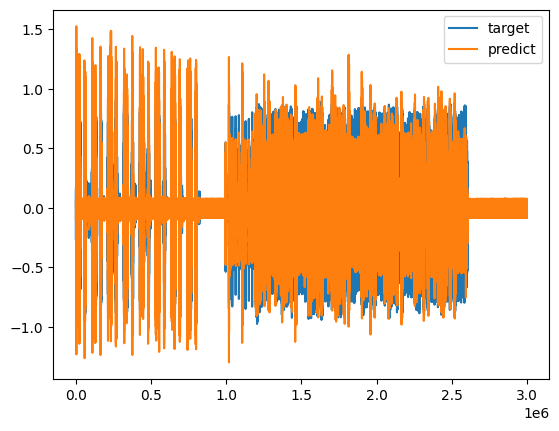

In [6]:
# Eval
pred = torch.empty_like(input_valset)
model.eval()
loss = 0
for i in range(math.ceil(input_valset.shape[0] / batch_size)):
    input_batch = input_valset[i*batch_size : i*batch_size+batch_size, :, :]
    val_batch = target_valset[i*batch_size : i*batch_size+batch_size, :, :]
    pred_batch = torch.empty_like(input_batch)
    for k in range(math.ceil(input_batch.shape[1] / sequence_size)):
        pred_batch[:, k*sequence_size : k*sequence_size+sequence_size, :] = model(input_batch[:, k*sequence_size : k*sequence_size+sequence_size, :])
        batch_loss += loss_function(pred_batch[:, k*sequence_size : k*sequence_size+sequence_size, :], val_batch[:, k*sequence_size : k*sequence_size+sequence_size, :])
    batch_loss /= (k + 1)
    loss += batch_loss
    pred[i*batch_size : i*batch_size+batch_size] = pred_batch
loss /= (i + 1)
print("Val loss {}".format(loss))

# Plot target and pred
pred = torch.flatten(pred).detach().to(torch.device("cpu")).numpy()
target = torch.flatten(target_valset).detach().to(torch.device("cpu")).numpy()
origin = torch.flatten(input_valset).detach().to(torch.device("cpu")).numpy()
# pred = np.convolve(pred, h)
# Anti aliasing

plt.figure(2)
plt.plot(target, label="target")
plt.plot(pred, label="predict")
plt.legend()
plt.show()

write_wav_file("pred.wav", pred, 44100)
write_wav_file("target.wav", target, 44100)